<a href="https://colab.research.google.com/github/Jasper-Hewitt/privatestuff/blob/main/GaoHongan_Twitter_predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 73.4 MB/s 
     |████████████████████████████████| 212 kB 67.5 MB/s 
     |████████████████████████████████| 132 kB 70.3 MB/s 
     |████████████████████████████████| 127 kB 70.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 47.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninsta

In [ ]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [ ]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [ ]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_GaoHongan.xlsx

--2022-12-10 05:45:12--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_GaoHongan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358154 (350K) [application/octet-stream]
Saving to: ‘scrap_GaoHongan.xlsx’

scrap_GaoHongan.xls 100%[===================>] 349.76K  --.-KB/s    in 0.03s   

2022-12-10 05:45:13 (10.2 MB/s) - ‘scrap_GaoHongan.xlsx’ saved [358154/358154]



In [ ]:
import pandas as pd

In [ ]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_GaoHongan.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [ ]:
#dirty data
testing_pd

,text
0,"三立iNEWS\n@inewsknowledge\n·\n20m于北辰曝""高虹安對柯P超不爽..."
1,三戒\n@xuyuinfo5\n·\n37mReplying to \n@al6wul4wu...
2,高詩特\n@hqvSpv2SoXIj4Zn\n·\n46m蔣萬安留首長搶輸高虹安？ 柯文哲笑...
3,Kuán Kui-Tîng\n@guanguiting\n·\n1hReplying to ...
4,"三立LIVE新聞\n@setlivenews\n·\n1h周玉蔻預言""一辭立委就被收押""! ..."
...,...
1845,彭帥泉\n@penghsinchuan\n·\n26 NovReplying to \n@o...
1846,bjjsyh\n@ronghaibo\n·\n26 Nov如果高虹安在新竹胜选的话，某种意义...
1847,同盟会王超\n@HIoVYPWGkYW8GB9\n·\n26 Nov决战九合一之新竹选情反转...
1848,LordSaga\n@LordSaga10\n·\n26 Nov台湾马上县市长选举，根据经常...


In [ ]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [ ]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,"三立\n\n·\n于北辰曝""高虹安對柯超不爽！"" 虹辦助理繳公積金 當月應退款竟比薪水還高！..."
1,三戒\n\n·\n \n\n关于高虹安未来动向的几点猜测，\n①放弃就任新竹市长，继续担任...
2,高詩特\n\n·\n蔣萬安留首長搶輸高虹安？ 柯文哲笑：我的局處長太優秀\n柯文哲將帥無能，...
3,á -î\n\n·\n \n\n會使，棄職著無就職後立委自動辭職兮問題。不過立法此會期只到...
4,"三立新聞\n\n·\n周玉蔻預言""一辭立委就被收押""! 高虹安否認國庫通黨庫 強調江青山跟拍..."
...,...
1845,彭帥泉\n\n·\n \n\n新竹的秘密會在未來公諸於世，凡走過必留痕跡，若有人貪污舞弊...
1846,\n\n·\n 如果高虹安在新竹胜选的话，某种意义上是台湾民主的倒退。
1847,同盟会王超\n\n·\n 决战九合一之新竹选情反转\n民众党高虹安一骑绝尘冲杀新竹，本来没有...
1848,\n\n·\n 台湾马上县市长选举，根据经常看的节目预测一波，对照开票结果就知是不是同温层取...


## 1-2 Tokenization

In [ ]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [ ]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/909 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-16-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import numpy as np

#prediction results


In [ ]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1850
  Batch size = 8


In [ ]:
pred

PredictionOutput(predictions=array([[ 2.5047688, -3.7293751],
       [ 1.852849 , -2.4402454],
       [ 1.4331186, -1.384996 ],
       ...,
       [ 1.4788158, -1.7550831],
       [-1.950034 ,  1.9948411],
       [-1.591887 ,  1.5008669]], dtype=float32), label_ids=None, metrics={'test_runtime': 57.4978, 'test_samples_per_second': 32.175, 'test_steps_per_second': 4.035})

In [ ]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [ ]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,"三立\n\n·\n于北辰曝""高虹安對柯超不爽！"" 虹辦助理繳公積金 當月應退款竟比薪水還高！...",0
1,三戒\n\n·\n \n\n关于高虹安未来动向的几点猜测，\n①放弃就任新竹市长，继续担任...,0
2,高詩特\n\n·\n蔣萬安留首長搶輸高虹安？ 柯文哲笑：我的局處長太優秀\n柯文哲將帥無能，...,0
3,á -î\n\n·\n \n\n會使，棄職著無就職後立委自動辭職兮問題。不過立法此會期只到...,0
4,"三立新聞\n\n·\n周玉蔻預言""一辭立委就被收押""! 高虹安否認國庫通黨庫 強調江青山跟拍...",0
...,...,...
1845,彭帥泉\n\n·\n \n\n新竹的秘密會在未來公諸於世，凡走過必留痕跡，若有人貪污舞弊...,1
1846,\n\n·\n 如果高虹安在新竹胜选的话，某种意义上是台湾民主的倒退。,0
1847,同盟会王超\n\n·\n 决战九合一之新竹选情反转\n民众党高虹安一骑绝尘冲杀新竹，本来没有...,0
1848,\n\n·\n 台湾马上县市长选举，根据经常看的节目预测一波，对照开票结果就知是不是同温层取...,1


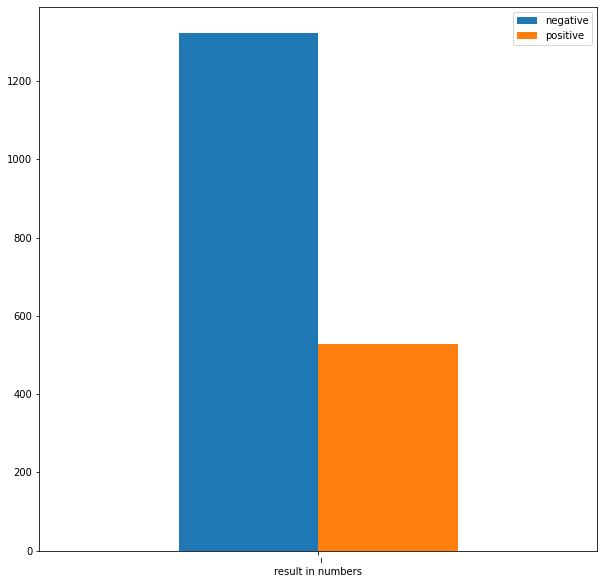

In [ ]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

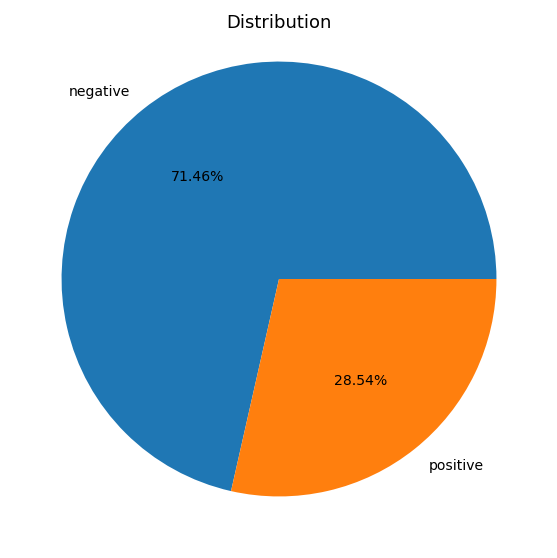

In [ ]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);